# AutoRegressive Returns Differential

diego.alvarez@colorado.edu <br>
10/02/2023

# Packages

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf

# Load Data

In [2]:
parent_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_path = os.path.join(parent_path, "data")
em_prices_path = os.path.join(data_path, "em_prices.parquet")
dm_prices_path = os.path.join(data_path, "data.parquet")

# Prep and Calculate

In [3]:
df_em = (pd.read_parquet(
    path = em_prices_path,
    engine = "pyarrow").
    query("field == 'PX_LAST'").
    drop(columns = ["field"]).
    assign(ticker = lambda x: x.ticker.str.split(" ").str[0]).
    pivot(index = "date", columns = "ticker", values = "value").
    dropna().
    pct_change(periods = 3 * 30).
    dropna().
    assign(em_spread = lambda x: x.MXWO - x.M1WOEW)
    [["em_spread"]].
    reset_index().
    melt(id_vars = "date"))

df_dm = (pd.read_parquet(
    path = dm_prices_path, engine = "pyarrow")
    ["Adj Close"].
    dropna().
    pct_change(periods = 3 * 30).
    dropna().
    assign(dm_spread = lambda x: x.SPY - x.RSP)
    [["dm_spread"]].
    reset_index().
    rename(columns = {"Date": "date"}).
    melt(id_vars = "date").
    rename(columns = {"variable": "ticker"}))

df_spread = pd.concat([df_em, df_dm])

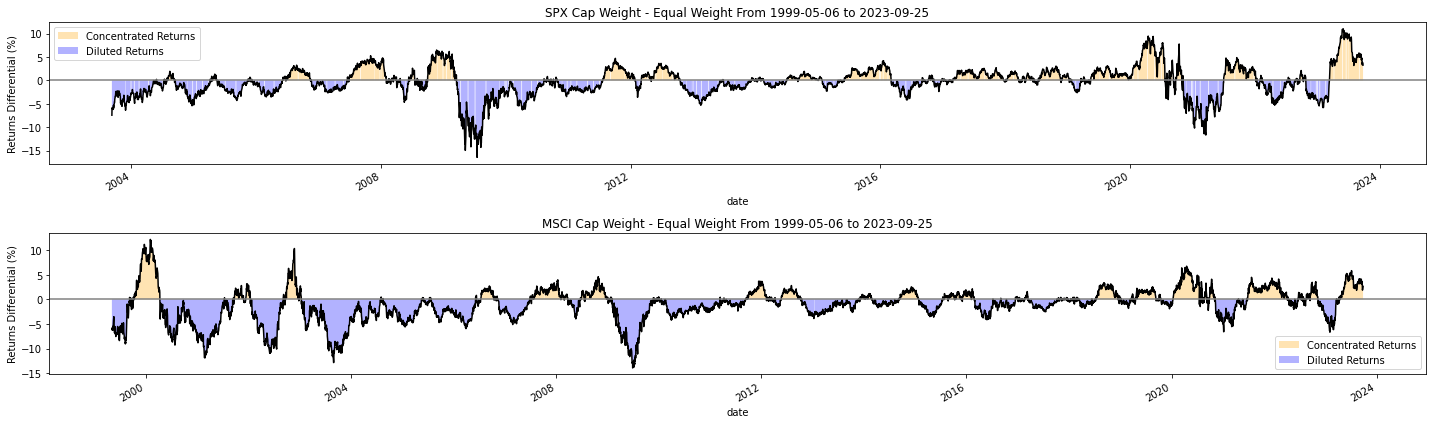

In [4]:
col_renamer = {
        "dm_spread": "SPX Cap Weight - Equal Weight",
        "em_spread": "MSCI Cap Weight - Equal Weight"}

df_plot = (df_spread.assign(
    value = lambda x: x.value * 100).
    pivot(index = "date", columns = "ticker", values = "value"))

cols = df_plot.columns.to_list()
fig, axes = plt.subplots(nrows = 2, figsize = (20,6))
for i, col in enumerate(cols):
    
    (df_plot[
        [col]].
        dropna().
        plot(
            ax = axes[i],
            legend = False,
            color = "black",
            ylabel = "Returns Differential (%)",
            title = "{} From {} to {}".format(
                col_renamer[col],
                df_plot.index.min().date(),
                df_plot.index.max().date())))
    
    axes[i].axhline(0, color = "grey")
    
    axes[i].fill_between(
        x = df_plot.index,
        y1 = df_plot[col],
        y2 = 0,
        where = df_plot[col] < 0,
        facecolor = "blue",
        alpha = 0.3)
    
    axes[i].fill_between(
        x = df_plot.index,
        y1 = df_plot[col],
        y2 = 0,
        where = df_plot[col] > 0,
        facecolor = "orange",
        alpha = 0.3)

    legend_elements = [
        Patch(facecolor = "orange", alpha = 0.3, label = "Concentrated Returns"),
        Patch(facecolor = "blue", alpha = 0.3, label = "Diluted Returns")]
    
    axes[i].legend(handles = legend_elements)
    

plt.tight_layout()

# Stationarity Test

In [5]:
def _ad_fuller_test(df: pd.DataFrame) -> None:
    
    ad_fuller = (adfuller(
        x = df.value,
        autolag = "AIC"))
    
    print("P-Value:", ad_fuller[1])

(df_spread.groupby(
    "ticker").
    apply(_ad_fuller_test))

P-Value: 7.802830458456904e-05
P-Value: 2.8099349517613626e-08


""


# AR Test

In [6]:
def _split_data(df: pd.DataFrame) -> pd.DataFrame:
    
    df_count = (df.assign(
        count = range(1, len(df) + 1)))
    
    cutoff_value = int(2 * len(df_count) / 3)
    
    df_insample = (df_count.query(
        "count < @cutoff_value").
        assign(sample = "in_sample"))
    
    df_outsample = (df_count.query(
        "count >= @cutoff_value").
        assign(sample = "out_sample"))

    df_out = (pd.concat(
        [df_insample, df_outsample]).
        drop(columns = ["count"]))
    
    return(df_out)

df_sample = (df_spread.groupby(
    "ticker").
    apply(_split_data))

In [7]:
def _ar(df: pd.DataFrame) -> pd.DataFrame:
    
    df_in_sample = df.query("sample == 'in_sample'")
    df_out_sample = df.query("sample == 'out_sample'")
    
    ar_model = (AutoReg(
        df_in_sample["value"], lags = 8).
        fit())
    
    pred = ar_model.predict(
        start = len(df_in_sample), end = len(df) - 1)
    
    return(pd.DataFrame({
        "prediction": pred,
        "date": df_out_sample.date}))
    
ar_prediction = (df_sample.groupby(
    "ticker").
    apply(_ar).
    reset_index().
    drop(columns = ["level_1"]).
    assign(group = "prediction"))

In [8]:
df_pred_sample = (df_sample.query(
    "sample == 'out_sample'").
    rename(columns = {"sample": "group"}).
    append((ar_prediction.rename(columns = {"prediction": "value"}))))

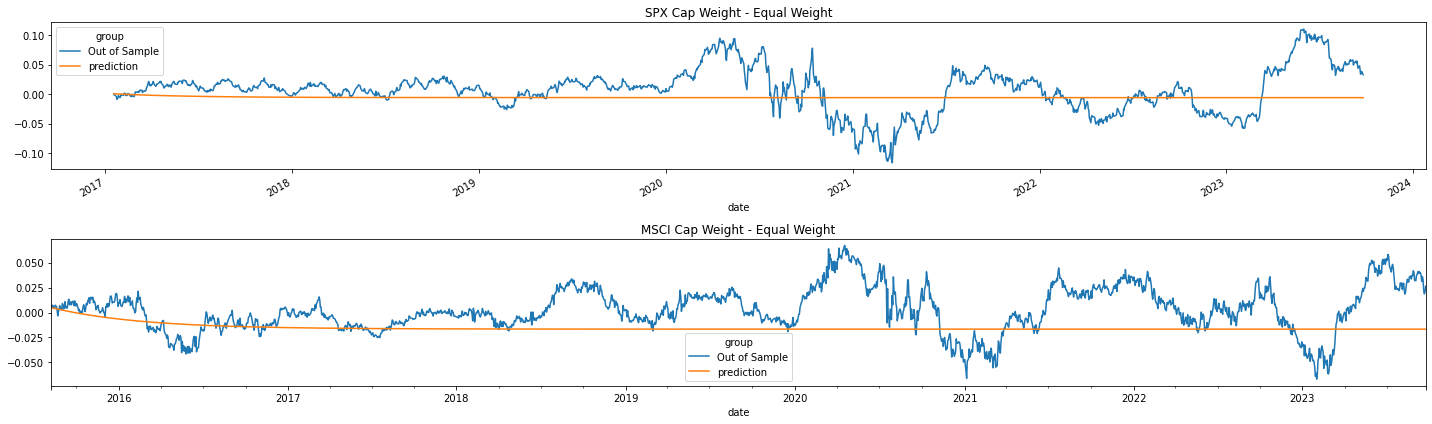

In [9]:
tickers = df_pred_sample.ticker.drop_duplicates().to_list()
fig, axes = plt.subplots(nrows = len(tickers), figsize = (20,6))

for i, ticker in enumerate(tickers):
    
    (df_pred_sample.query(
        "ticker == @ticker").
        drop(columns = ["ticker"]).
        pivot(index = "date", columns = "group", values = "value").
        rename(columns = {"out_sample": "Out of Sample"}).
        plot(
            ax = axes[i],
            title = col_renamer[ticker]))
    
plt.tight_layout()

# ARMA Model